In [5]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from implementations import *
import build_polynomial
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load the training data into feature matrix, class labels, and event ids:

In [2]:
from proj1_helpers import *
DATA_TRAIN_PATH = '../data/train.csv' # TODO: download train data and supply path here 
y, tX, ids = load_csv_data(DATA_TRAIN_PATH)
y.shape, tX.shape, ids.shape


((250000,), (250000, 30), (250000,))

In [4]:
tX_standardized, tX_mean, tX_std= standardize(tX)

## Do your thing crazy machine learning thing here :) ...

[ 8.07776850e-05 -7.20720767e-03 -6.04555312e-03 -5.52237771e-04
 -1.94626017e-02  4.73630668e-04 -2.60461377e-02  3.24416503e-01
 -3.08888742e-05  4.40605445e-03 -2.20821472e-01  9.50529745e-02
  6.40680369e-02  3.85825312e-03 -3.30776414e-04 -9.58259329e-04
  8.59764255e-03 -5.31543295e-04  9.73080496e-04  3.69968142e-03
  3.54452867e-04 -5.44709539e-04 -3.29715222e-01 -1.39957102e-03
  8.20802895e-04  1.02264536e-03 -1.67330138e-03 -5.82147278e-03
 -1.10813345e-02 -3.95559662e-03]


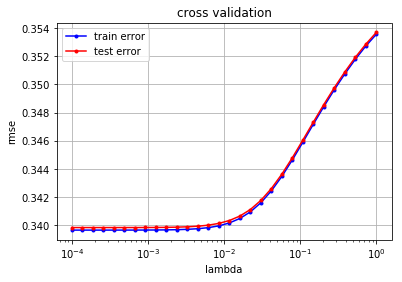

In [51]:
def build_k_indices(y, k_fold, seed):
    """build k indices for k-fold."""
    num_row = y.shape[0]
    interval = int(num_row / k_fold)
    np.random.seed(seed)
    indices = np.random.permutation(num_row)
    k_indices = [indices[k * interval: (k + 1) * interval] for k in range(k_fold)]
    return np.array(k_indices)

def cross_validation(y, tX, k_indices, k, lambda_, degree):
    """return the loss of ridge regression."""
    # ***************************************************
    # INSERT YOUR CODE HERE
    # get k'th subgroup in test, others in train: TODO
    tr_indice = k_indices[~(np.arange(k_indices.shape[0]) == k)]
    tr_indice = tr_indice.reshape(-1)
    tX_te=tX[k_indices[k]]
    tX_tr=tX[tr_indice]
    y_te=y[k_indices[k]]
    y_tr=y[tr_indice]
    # ***************************************************
    # ***************************************************
    # ***************************************************
    # INSERT YOUR CODE HERE
    # ridge regression: TODO
    [loss_tr,w]=ridge_regression(y_tr,tX_tr,lambda_)
    # ***************************************************
    # ***************************************************
    # INSERT YOUR CODE HERE
    # calculate the loss for train and test data: TODO
    loss_te=compute_loss(y_te,tX_te,w)
    # ***************************************************
    return loss_tr, loss_te, w

from plots import cross_validation_visualization

def cross_validation_best_weight():
    seed = 101
    degree = 7
    k_fold = 4
    lambdas = np.logspace(-4, 0, 30)
    # split data in k fold
    k_indices = build_k_indices(y, k_fold, seed)
    # define lists to store the loss of training data and test data
    rmse_tr = []
    rmse_te = []
    weights=[]
    # ***************************************************
    # INSERT YOUR CODE HERE
    # cross validation: TODO
    for lambda_ in lambdas:
        rmse_tr_l=[]
        rmse_te_l=[]
        w_l=[]
        for k in range(k_fold):
            cv_res=cross_validation(y, tX, k_indices, k, lambda_, degree)
            rmse_tr_l.append(cv_res[0])
            rmse_te_l.append(cv_res[1])
            w_l.append(cv_res[2])
        rmse_tr.append(np.mean(rmse_tr_l))
        rmse_te.append(np.mean(rmse_te_l))
        weights.append(np.mean(w_l,axis=0))
    # *************************************************** 
    best_index=np.argmin(rmse_te)
    cross_validation_visualization(lambdas, rmse_tr, rmse_te)
    print(weights[best_index])
    return weights[best_index]
weights=cross_validation_best_weight()

# Generate predictions and save ouput in csv format for submission:

In [52]:
DATA_TEST_PATH = '../data/test.csv' # TODO: download test data and supply path here 
_, tX_test, ids_test = load_csv_data(DATA_TEST_PATH)

In [54]:
OUTPUT_PATH = '../data/pred.csv' # TODO: fill in desired name of output file for submission
y_pred = predict_labels(weights, tX_test)
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)